In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

# add parent directory to sys path so we could access project modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

In [93]:
# Perfrom Extracting
# and convert column tools from string to list
df = pd.read_csv("../jobs.csv", converters={
    'tools': literal_eval,
    "country": literal_eval,
    "employment_type": literal_eval
})
df.head()

,country,date_time,employment_type,num_applications,num_views,tools,year_of_exp
0,"[Ukraine, Portugal, Spain, Argentina, Chile]",18:30 06.05.2024,[Remote],10,37,"[Code, Native, IaC, Infrastructure, CD, Cloud]",5
1,[Ukraine],18:16 06.05.2024,[Remote],24,67,"[Pika, SQLAlchemy, Celery Beat, AWS, Docker, P...",3
2,"[Ukraine, Cyprus]",15:30 06.05.2024,[Remote],2,19,"[CAPTCHAs, Selenium, Redis, DDD, GCS, SSL, Pyt...",5
3,[Ukraine],15:08 06.05.2024,"[Office, Remote]",25,76,"[CD, Linux, Git, Docker]",3
4,[Israel],14:10 06.05.2024,[Remote],22,219,"[Async IO, Great, AWS, GCP, Auto, Azure, Quick...",5


In [3]:
# Perfrom Cleaning, Wrangling

# change year of exp to data type int8
df.loc[:, "year_of_exp"] = df.year_of_exp.astype(np.int8)

# to datetime objects
df.loc[:, "date_time"] = pd.to_datetime(df.date_time, format="%H:%M %d.%m.%Y")

# remove rows where there is no tools
df = df[df.tools.astype(bool)]

In [79]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Define a function to remove duplicates and update counts
def removing_duplicates(tool_counts) -> dict:
    """
    Removing duplicates, exp 'AI', 'AI services' - is same,
    'AI' should stay, and 'AI services' count value should be
    added to 'AI' count
    """
    unq_words = {}
    duplicates = set()

    # Sort tool_counts by length of keys (tool names)
    tool_counts_sorted = tool_counts.sort_index(key=lambda v: v.str.len())

    for tool, count in tool_counts_sorted.items():
        if tool not in duplicates:
            matches = process.extractBests(
                tool, 
                tool_counts_sorted.index, 
                scorer=lambda str1, str2: fuzz.ratio(str1.lower(), str2.lower()),
                score_cutoff=70
            )
            
            # Filter out matches that are similar to the current tool
            filtered_matches = {match for match, score in matches if match != tool and (
                match.lower().startswith(tool.lower()) or score >= 85
            )}
            
            # Add count of similar tools to the current tool
            unq_words[tool] = count + sum(tool_counts[match] for match in filtered_matches)
            duplicates |= filtered_matches

    return unq_words

In [ ]:
# Concatenate all tools into one Series
all_tools = pd.Series(df['tools'].sum())

# Count the occurrences of each tool
tool_counts = all_tools.value_counts()

# Remove duplicates and update counts
tools_dict = removing_duplicates(tool_counts)

# Create DataFrame from dictionary
tools_df = pd.DataFrame({'tools': list(tools_dict.keys()), 'count': list(tools_dict.values())})

# Sort DataFrame by count in descending order
tools_df = tools_df.sort_values(by='count', ascending=False)
tools_df.to_csv("tools.csv", index=False)

tools_df.head()

In [56]:
tools = pd.read_csv("tools.csv")

,tools,count
0,Python,287
1,English,102
2,Sql,93
3,AWS,85
4,Docker,76
5,Django,68
6,Postgres,68
7,CI/CD,59
8,API,57
9,Javascript,55


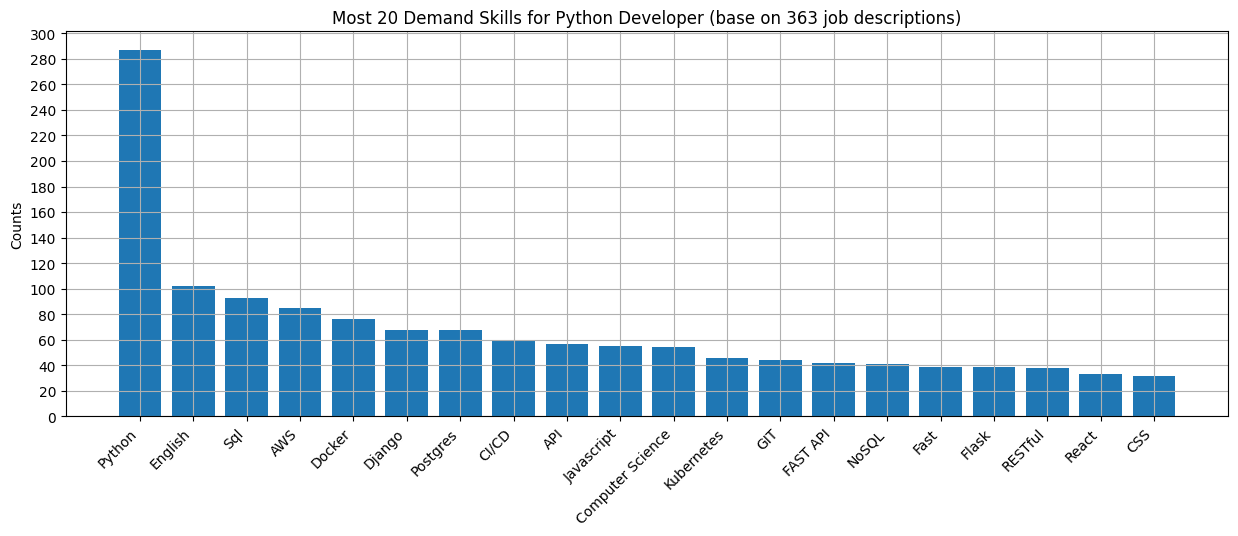

In [51]:
# perform Transforming
import os
import sys

from config import POSITION

# get top 20 demands
top_tools = tools.iloc[:20, :]

plt.figure(figsize=(15, 5))
plt.bar(top_tools.tools, top_tools["count"])

plt.title(f"TOP 20 Demand Skills for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, tools["count"].max() + 20, 20))
plt.grid(True)
plt.show()

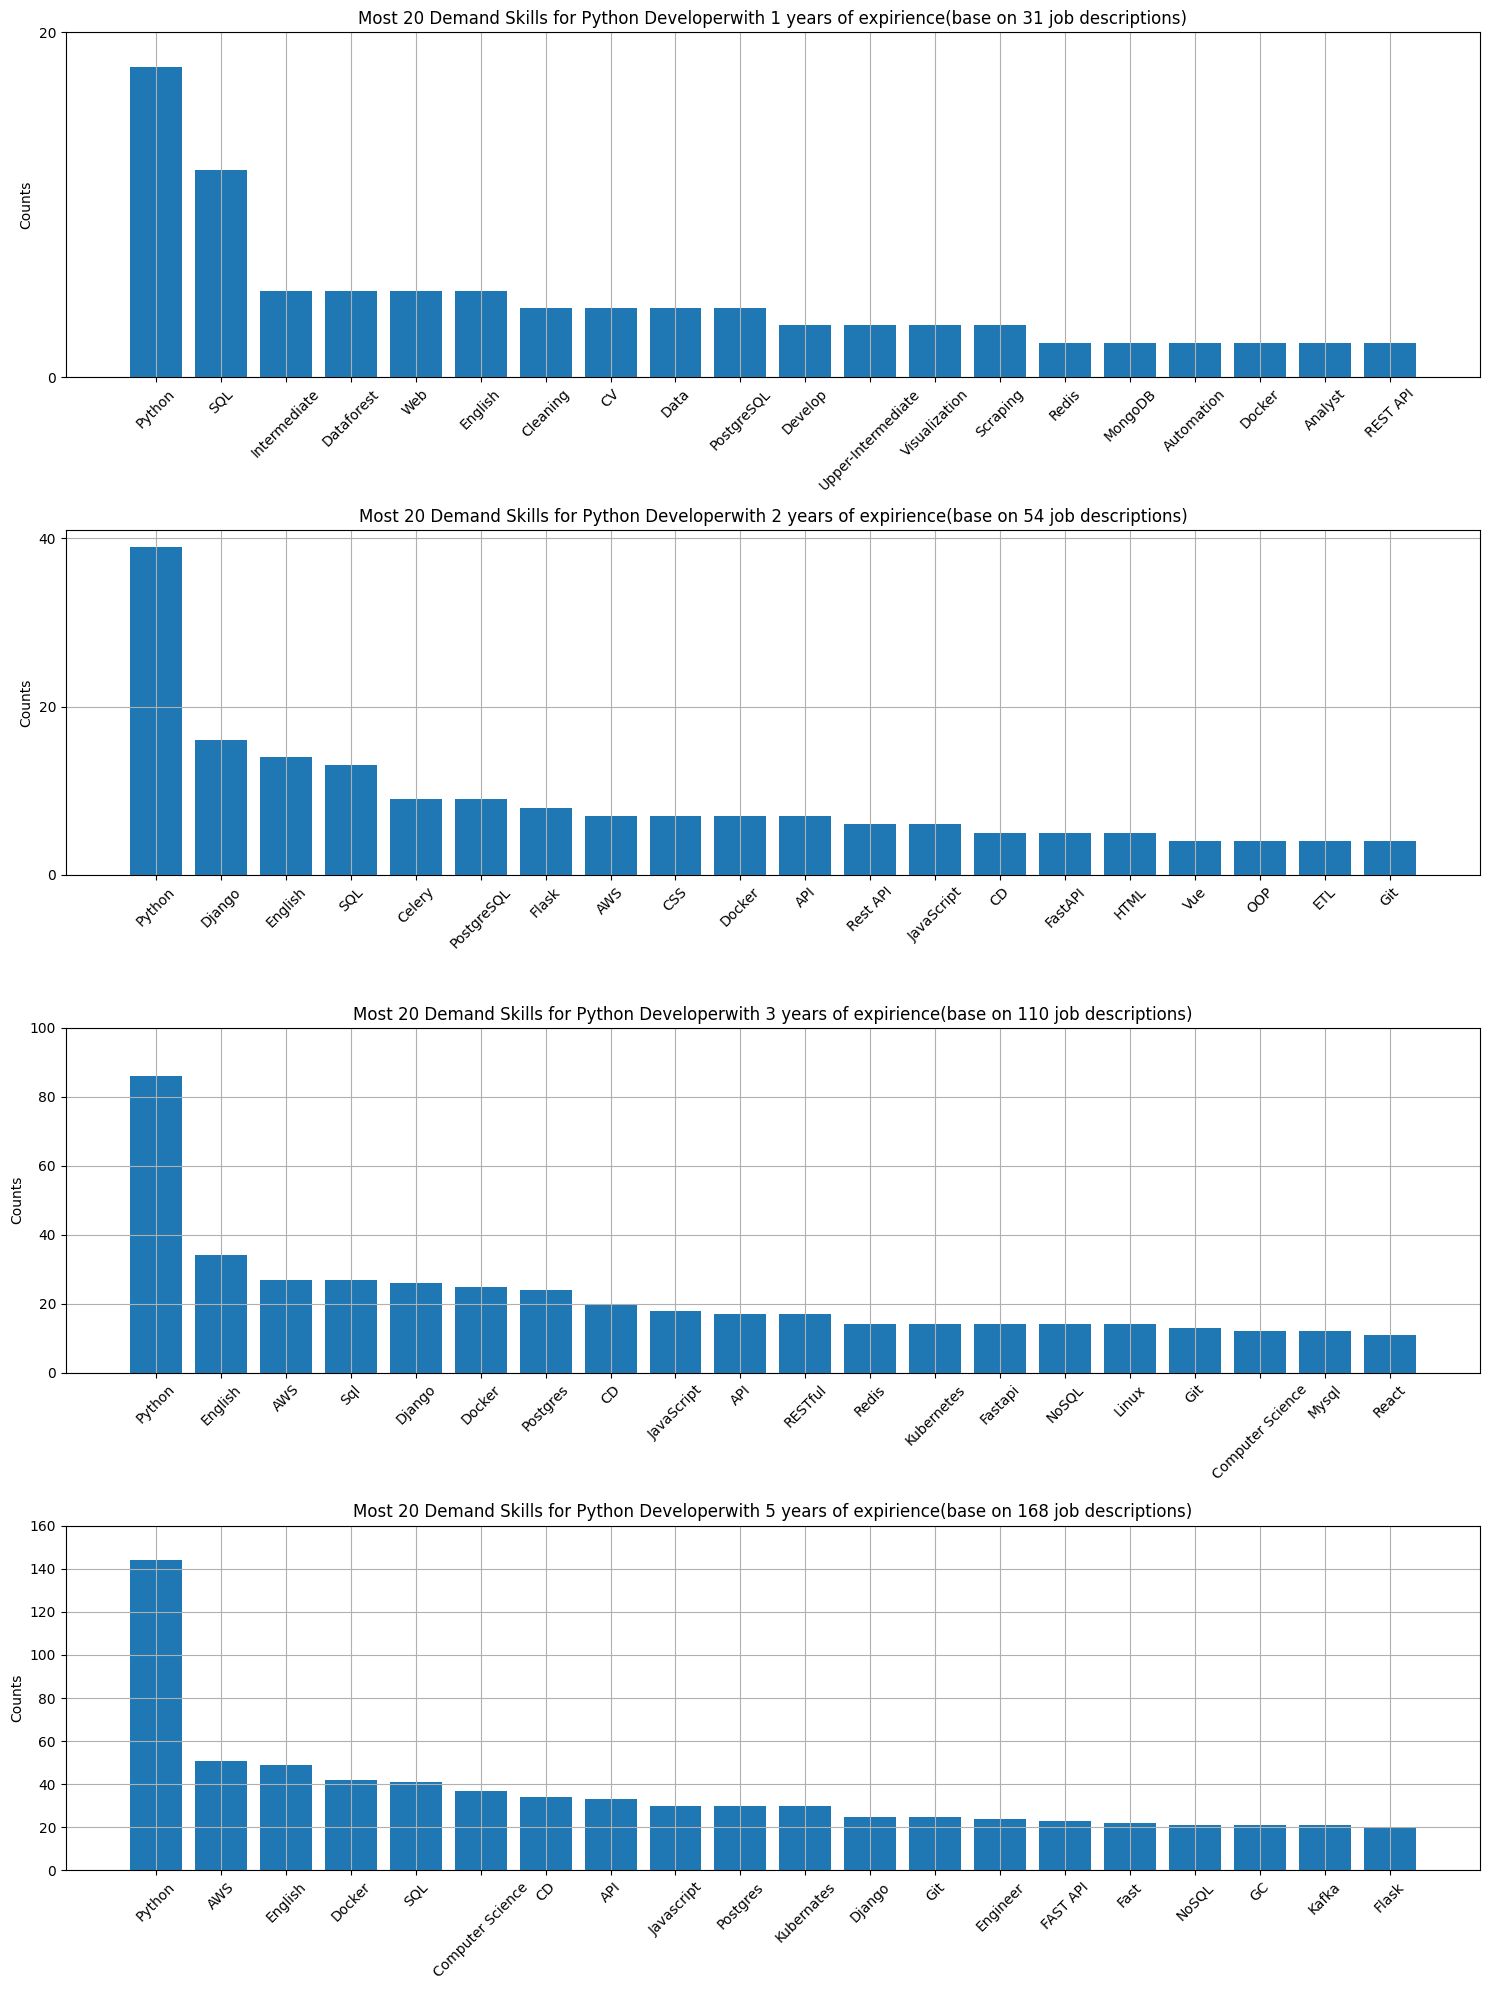

In [89]:
# group by year of expirience
grouped = df.groupby("year_of_exp")

fig, axes = plt.subplots(nrows=len(grouped), figsize=(15, 5 * len(grouped)))

# create a bar plot for each year of exprience
for i, (year, data) in enumerate(grouped):
    ax = axes[i] if len(grouped) > 1 else axes

    all_skills = pd.Series(data['tools'].sum())
    # Count the occurrences of each tool
    skill_counts = all_skills.value_counts()
    
    skills = removing_duplicates(skill_counts)
    # Create DataFrame from dictionary
    skills = pd.DataFrame({'tools': list(skills.keys()), 'count': list(skills.values())})
    # Sort DataFrame by count in descending order
    skills = skills.sort_values(by='count', ascending=False)
    
    top_tools = skills.iloc[:20, :]
    ax.bar(top_tools.tools, top_tools["count"])
    
    ax.set_title((
        f"TOP {len(top_tools)} Demand Skills for {POSITION} Developer"
        f"with {year} years of expirience(base on {len(data)} job descriptions)"
    ))
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_ylabel("Counts")
    ax.set_yticks(range(0, top_tools["count"].max() + 20, 20))
    ax.grid(True)

plt.tight_layout()
plt.show()

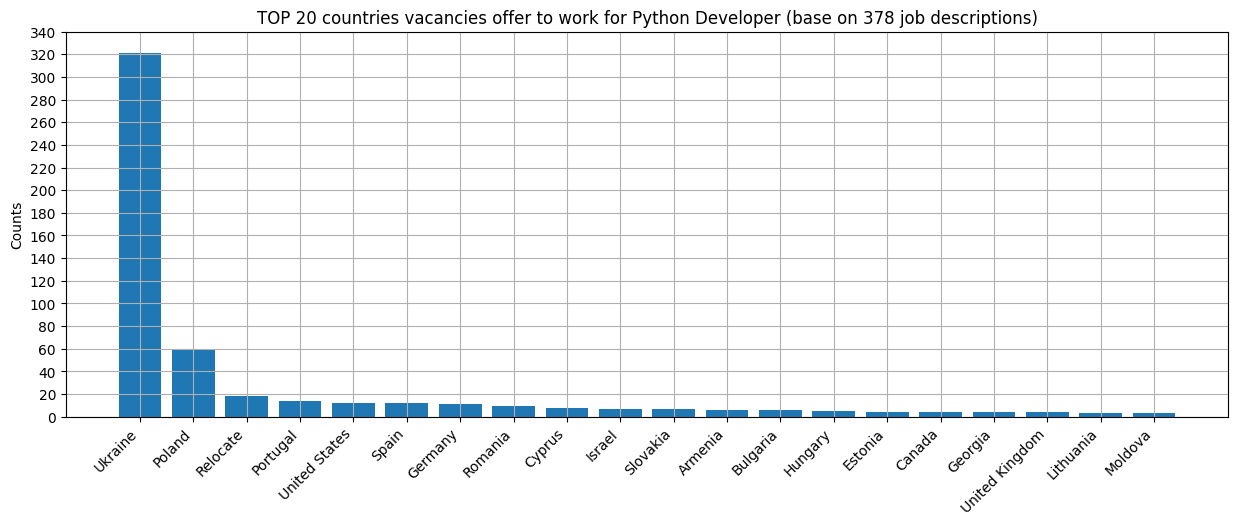

In [112]:
# See djinni Job Locations
countries = pd.Series(df.country.sum())
countries = countries.value_counts()

# get top 20 countries job vacancies offering
top_countries = countries[:20]

plt.figure(figsize=(15, 5))
plt.bar(top_countries.index, top_countries)

plt.title(f"TOP {len(top_countries)} countries vacancies offer to work for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, countries.max() + 20, 20))
plt.grid(True)
plt.show()

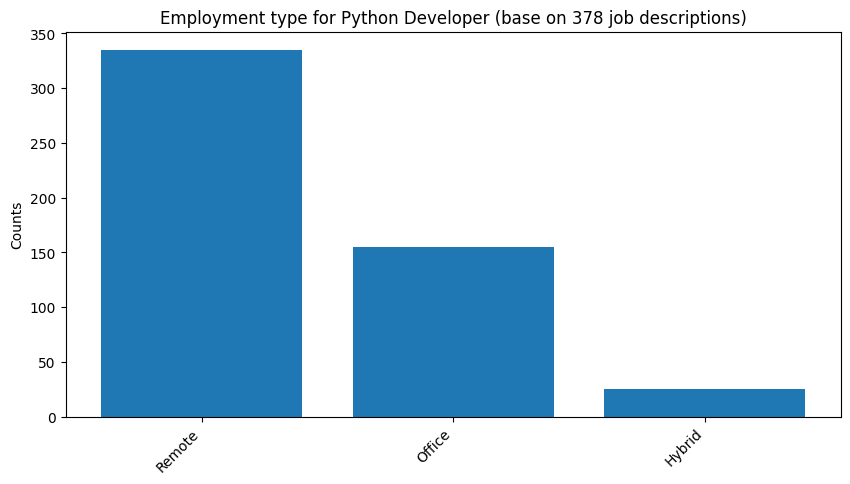

In [113]:
# See djinni employment type
empl_type = pd.Series(df.employment_type.sum())
empl_type = empl_type.value_counts()

# get top 20 employment type job vacancies offers
top_empl_types = empl_type[:20]

plt.figure(figsize=(10, 5))
plt.bar(top_empl_types.index, top_empl_types)

plt.title(f"Employment type for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.show()

In [114]:
df.head()

,country,date_time,employment_type,num_applications,num_views,tools,year_of_exp
0,"[Ukraine, Portugal, Spain, Argentina, Chile]",18:30 06.05.2024,[Remote],10,37,"[Code, Native, IaC, Infrastructure, CD, Cloud]",5
1,[Ukraine],18:16 06.05.2024,[Remote],24,67,"[Pika, SQLAlchemy, Celery Beat, AWS, Docker, P...",3
2,"[Ukraine, Cyprus]",15:30 06.05.2024,[Remote],2,19,"[CAPTCHAs, Selenium, Redis, DDD, GCS, SSL, Pyt...",5
3,[Ukraine],15:08 06.05.2024,"[Office, Remote]",25,76,"[CD, Linux, Git, Docker]",3
4,[Israel],14:10 06.05.2024,[Remote],22,219,"[Async IO, Great, AWS, GCP, Auto, Azure, Quick...",5


In [119]:
df[["num_applications", "num_views", "year_of_exp"]].corr()

,num_applications,num_views,year_of_exp
num_applications,1.000000,0.887896,-0.335618
num_views,0.887896,1.000000,-0.407813
year_of_exp,-0.335618,-0.407813,1.000000
